In [1]:
import numpy as np
import pandas as pd
from scipy.stats import sem, t
from scipy.integrate import odeint
#from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#import os
import statsmodels.api as sm

### Problem 1

In [2]:
def initialize_grid(grid_size, agent_ratio):
    grid = np.random.choice([0, 1, 2], size=(grid_size, grid_size), p=[0.5, agent_ratio, 0.25])
    return grid

In [3]:
def morans_I(grid):
    n = grid.size
    mean = np.mean(grid)
    S0 = np.sum((grid - mean) ** 2)
    W = np.zeros_like(grid, dtype=int)
    W[1:] += grid[:-1]  # Top neighbors
    W[:-1] += grid[1:]  # Bottom neighbors
    W[:, 1:] += grid[:, :-1]  # Left neighbors
    W[:, :-1] += grid[:, 1:]  # Right neighbors
    W[1:, 1:] += grid[:-1, :-1]  # Top-left neighbors
    W[:-1, :-1] += grid[1:, 1:]  # Bottom-right neighbors
    W[:-1, 1:] += grid[1:, :-1]  # Bottom-left neighbors
    W[1:, :-1] += grid[:-1, 1:]  # Top-right neighbors
    W[grid == 0] = 0  # Exclude empty cells
    W = np.where(W > 0, 1, 0)  # Convert to binary weights
    S1 = np.sum(W * (grid - mean)[:, np.newaxis] * (grid - mean))
    morans_I = (n / (2 * np.sum(W))) * (S1 / S0)
    return morans_I

In [4]:
def update_grid(grid):
    new_grid = grid.copy()
    for i in np.random.permutation(grid.shape[0]):
        for j in np.random.permutation(grid.shape[1]):
            agent_type = grid[i, j]
            if agent_type != 0:  # Only consider non-empty cells
                different_neighbors = 0
                same_neighbors = 0
                total_neighbors = 0
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        if di == dj == 0:
                            continue
                        ni, nj = i + di, j + dj
                        if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1]:
                            neighbor_type = grid[ni, nj]
                            if neighbor_type != 0:  # Only consider non-empty cells as neighbors
                                total_neighbors += 1
                                if neighbor_type == agent_type:
                                    same_neighbors += 1
                                else:
                                    different_neighbors += 1

                # Calculate the tolerance level based on the agent's preference
                tolerance_level = 0.5  # Example: Agents want at least 50% of their neighbors to be of the same type

                # Check if the agent's tolerance level is satisfied
                if same_neighbors < tolerance_level * total_neighbors:
                    # Find an empty cell within the neighborhood to move to
                    empty_neighbors = []
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            if di == dj == 0:
                                continue
                            ni, nj = i + di, j + dj
                            if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1] and new_grid[ni, nj] == 0:
                                empty_neighbors.append((ni, nj))

                    if len(empty_neighbors) > 0:
                        new_position = empty_neighbors[np.random.randint(len(empty_neighbors))]
                        new_grid[new_position[0], new_position[1]] = agent_type
                        new_grid[i, j] = 0

    return new_grid

In [5]:
grid_size = 5
agent_ratio = 0.25
num_steps = 1000 
num_conditions = 100

In [6]:
morans_I_values = np.zeros((num_conditions, num_steps))
grids = np.zeros((num_conditions, num_steps+1, grid_size, grid_size))
# Simulate the Shelling model for each initial condition
for condition in range(num_conditions):
    grid = initialize_grid(grid_size, agent_ratio)
    grids[condition, 0] = grid
    for step in range(num_steps):
        # Compute Moran's I for the current step and store in array
        morans_I_values[condition, step] = morans_I(grid)
        # Update the grid
        grid = update_grid(grid)
        grids[condition, step+1] = grid

In [23]:
grids[12,0]

array([[2., 2., 0., 0., 0.],
       [2., 0., 0., 2., 1.],
       [1., 0., 1., 0., 0.],
       [1., 2., 0., 2., 0.],
       [2., 0., 1., 2., 2.]])

In [22]:
grids[12,-1]

array([[2., 2., 0., 1., 0.],
       [2., 0., 1., 0., 0.],
       [1., 1., 1., 0., 2.],
       [0., 0., 0., 2., 0.],
       [0., 2., 2., 2., 2.]])

In [9]:
morans_I_values

array([[0.63131313, 0.43560606, 0.33880471, ..., 0.15546086, 0.58159722,
        0.15546086],
       [1.50159051, 1.53412377, 1.68956044, ..., 1.30819838, 1.30819838,
        1.30819838],
       [0.48786181, 0.70961718, 0.70961718, ..., 0.97676107, 0.97676107,
        0.97676107],
       ...,
       [0.52599862, 0.11244437, 0.17005722, ..., 0.36872219, 0.36872219,
        0.36872219],
       [0.24253132, 0.27532391, 0.41887515, ..., 0.41887515, 0.41887515,
        0.41887515],
       [0.28445513, 0.56490385, 0.28445513, ..., 0.45448909, 0.45448909,
        0.45448909]])

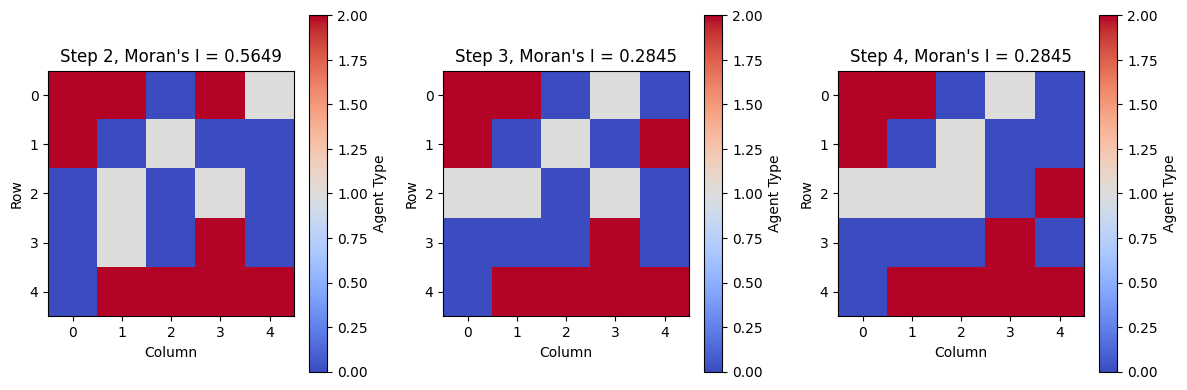

In [21]:
plt.figure(figsize=(12, 4))
for i, step in enumerate([1, 2, 3]):
    plt.subplot(1, 3, i+1)
    plt.imshow(grids[12, step+1], cmap='coolwarm', interpolation='nearest')
    plt.title(f'Step {step + 1}, Moran\'s I = {morans_I_values[condition, step]:.4f}')
    plt.colorbar(label='Agent Type')
    plt.xlabel('Column')
    plt.ylabel('Row')
plt.tight_layout()
plt.show()

For one realization and three consecutive steps, the thee plots are as expected. The agents in different steps tend to be clustered (segregation) step by step, and in every step, the agents which need move only move toward the empty cells of their 8 neighbors.

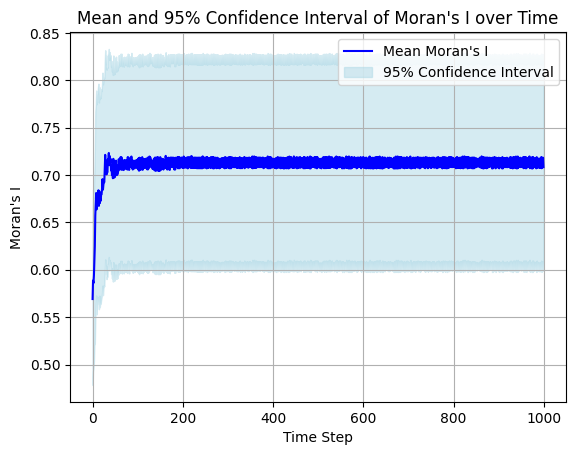

In [24]:
mean_morans_I = np.mean(morans_I_values, axis=0)
confidence_interval = t.ppf(0.975, num_conditions-1) * sem(morans_I_values, axis=0)

# Plot mean and confidence interval
plt.figure()
plt.plot(range(num_steps), mean_morans_I, color='blue', label='Mean Moran\'s I')
plt.fill_between(range(num_steps), mean_morans_I - confidence_interval, mean_morans_I + confidence_interval, color='lightblue', alpha=0.5, label='95% Confidence Interval')
plt.title('Mean and 95% Confidence Interval of Moran\'s I over Time')
plt.xlabel('Time Step')
plt.ylabel('Moran\'s I')
plt.legend()
plt.grid(True)
plt.show()

The mean and 95% Confidence Interval of Morans' I quickly improves from a relatively low base at first and reaches a relatively steady high within about ten steps. This shows that in this model, agents can achieve better clustering results over time, and finally present a better spatial isolation distribution.

### Problem 2

In [12]:
met_2019 = pd.read_excel('population_data\cbsa-met-est2019-annres.xlsx') 
met_2023 = pd.read_excel('population_data\cbsa-met-est2023-pop.xlsx') 
mic_2019 = pd.read_excel('population_data\cbsa-mic-est2019-annres.xlsx') 
mic_2023 = pd.read_excel('population_data\cbsa-mic-est2023-pop.xlsx') 
nst_2019 = pd.read_excel('population_data\\nst-est2019-01.xlsx') 
nst_2023 = pd.read_excel('population_data\\NST-EST2023-POP.xlsx') 

In [13]:
met_2019 = met_2019.iloc[2:420,:]
l = met_2019.iloc[0,:]
l = l.tolist()
l[0] = 'MetA'
met_2019.columns = l
met_2019.drop([2],inplace=True)
met_2019.dropna(inplace=True)

In [14]:
met_2019

,MetA,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,In Metropolitan Statistical Area,263096669,263107172,263659728,265915286.0,268257389.0,270477083.0,272833441.0,275213195.0,277549076.0,279600181.0,281282516.0,282828515.0
5,".Abilene, TX Metro Area",165252,165252,165585,166634.0,167442.0,167473.0,168342.0,169688.0,170017.0,170429.0,171150.0,172060.0
6,".Akron, OH Metro Area",703200,703196,703031,703200.0,702109.0,703621.0,704908.0,704382.0,703524.0,703987.0,703855.0,703479.0
7,".Albany, GA Metro Area",153857,154033,154145,154545.0,153976.0,152667.0,151949.0,150387.0,149137.0,148090.0,147840.0,146726.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,".Yakima, WA Metro Area",243231,243240,244256,245926.0,246127.0,246485.0,246870.0,247800.0,249327.0,249922.0,250562.0,250873.0
416,".York-Hanover, PA Metro Area",434972,435015,435413,436701.0,437466.0,438932.0,440475.0,441741.0,443693.0,445484.0,447847.0,449058.0
417,".Youngstown-Warren-Boardman, OH-PA Metro Area",565773,565782,564826,562347.0,558530.0,555850.0,553039.0,548798.0,544582.0,541545.0,538226.0,536081.0
418,".Yuba City, CA Metro Area",166892,166898,167099,166971.0,166963.0,167597.0,168311.0,169327.0,170694.0,172782.0,173905.0,175639.0


In [15]:
met_2023 = met_2023.iloc[2:429,:]
l = met_2023.iloc[0,:]
l = l.tolist()
l[0]='MetA'
l[1]='Estimates Base'
met_2023.columns = l
met_2023.drop([2],inplace=True)
met_2023.dropna(inplace=True)

In [16]:
met_2023

,MetA,Estimates Base,2020,2021.0,2022.0,2023.0
3,United States,331464948,331526933,332048977.0,333271411.0,334914895.0
4,.In Metropolitan Statistical Area,285662108,285741067,286200169.0,287378686.0,288910527.0
5,".Abilene, TX Metro Area",176562,176883,177831.0,179665.0,181591.0
6,".Akron, OH Metro Area",702225,701674,696512.0,697511.0,698398.0
7,".Albany, GA Metro Area",148915,148249,144933.0,145796.0,145508.0
...,...,...,...,...,...,...
424,".Yakima, WA Metro Area",256738,256733,256719.0,257019.0,256643.0
425,".York-Hanover, PA Metro Area",456441,456720,459183.0,461049.0,464640.0
426,".Youngstown-Warren, OH Metro Area",430676,429690,428101.0,426648.0,425969.0
427,".Yuba City, CA Metro Area",181214,181437,182379.0,182922.0,183670.0


In [17]:
met = met_2019.merge(met_2023,on='MetA')
met

,MetA,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,Estimates Base_y,2020,2021.0,2022.0,2023.0
0,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0,331464948,331526933,332048977.0,333271411.0,334914895.0
1,".Abilene, TX Metro Area",165252,165252,165585,166634.0,167442.0,167473.0,168342.0,169688.0,170017.0,170429.0,171150.0,172060.0,176562,176883,177831.0,179665.0,181591.0
2,".Akron, OH Metro Area",703200,703196,703031,703200.0,702109.0,703621.0,704908.0,704382.0,703524.0,703987.0,703855.0,703479.0,702225,701674,696512.0,697511.0,698398.0
3,".Albany, GA Metro Area",153857,154033,154145,154545.0,153976.0,152667.0,151949.0,150387.0,149137.0,148090.0,147840.0,146726.0,148915,148249,144933.0,145796.0,145508.0
4,".Albany-Schenectady-Troy, NY Metro Area",870716,870713,871082,872778.0,874698.0,877065.0,878113.0,879085.0,879792.0,882158.0,882263.0,880381.0,899247,899724,904824.0,903595.0,904682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,".Winston-Salem, NC Metro Area",640595,640503,641245,644266.0,646794.0,649901.0,653250.0,656277.0,661024.0,666640.0,671129.0,676008.0,675986,677134,682646.0,688799.0,695630.0
337,".Yakima, WA Metro Area",243231,243240,244256,245926.0,246127.0,246485.0,246870.0,247800.0,249327.0,249922.0,250562.0,250873.0,256738,256733,256719.0,257019.0,256643.0
338,".York-Hanover, PA Metro Area",434972,435015,435413,436701.0,437466.0,438932.0,440475.0,441741.0,443693.0,445484.0,447847.0,449058.0,456441,456720,459183.0,461049.0,464640.0
339,".Yuba City, CA Metro Area",166892,166898,167099,166971.0,166963.0,167597.0,168311.0,169327.0,170694.0,172782.0,173905.0,175639.0,181214,181437,182379.0,182922.0,183670.0


In [18]:
met_growth = met.copy()
met_growth['2010GR']=(met_growth[2010.0]-met_growth['Census'])/met_growth['Census']
met_growth['2011GR']=(met_growth[2011.0]-met_growth[2010])/met_growth[2010]
met_growth['2012GR']=(met_growth[2012.0]-met_growth[2011.0])/met_growth[2011.0]
met_growth['2013GR']=(met_growth[2013.0]-met_growth[2012.0])/met_growth[2012.0]
met_growth['2014GR']=(met_growth[2014.0]-met_growth[2013.0])/met_growth[2013.0]
met_growth['2015GR']=(met_growth[2015.0]-met_growth[2014.0])/met_growth[2014.0]
met_growth['2016GR']=(met_growth[2016.0]-met_growth[2015.0])/met_growth[2015.0]
met_growth['2017GR']=(met_growth[2017.0]-met_growth[2016.0])/met_growth[2016.0]
met_growth['2018GR']=(met_growth[2018.0]-met_growth[2017.0])/met_growth[2017.0]
met_growth['2019GR']=(met_growth[2019.0]-met_growth[2018.0])/met_growth[2018.0]
met_growth['2020GR']=(met_growth[2020]-met_growth[2019.0])/met_growth[2019.0]
met_growth['2021GR']=(met_growth[2021.0]-met_growth[2020])/met_growth[2020]
met_growth['2022GR']=(met_growth[2022.0]-met_growth[2021.0])/met_growth[2021.0]
met_growth['2023GR']=(met_growth[2023.0]-met_growth[2022.0])/met_growth[2022.0]

In [19]:
met_growth

,MetA,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,...,2014GR,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR
0,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,...,0.007302,0.007333,0.007192,0.006330,0.005237,0.004751,0.010015,0.001575,0.003681,0.004931
1,".Abilene, TX Metro Area",165252,165252,165585,166634.0,167442.0,167473.0,168342.0,169688.0,170017.0,...,0.005189,0.007996,0.001939,0.002423,0.004231,0.005317,0.028031,0.005359,0.010313,0.010720
2,".Akron, OH Metro Area",703200,703196,703031,703200.0,702109.0,703621.0,704908.0,704382.0,703524.0,...,0.001829,-0.000746,-0.001218,0.000658,-0.000188,-0.000534,-0.002566,-0.007357,0.001434,0.001272
3,".Albany, GA Metro Area",153857,154033,154145,154545.0,153976.0,152667.0,151949.0,150387.0,149137.0,...,-0.004703,-0.010280,-0.008312,-0.007020,-0.001688,-0.007535,0.01038,-0.022368,0.005954,-0.001975
4,".Albany-Schenectady-Troy, NY Metro Area",870716,870713,871082,872778.0,874698.0,877065.0,878113.0,879085.0,879792.0,...,0.001195,0.001107,0.000804,0.002689,0.000119,-0.002133,0.021971,0.005668,-0.001358,0.001203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,".Winston-Salem, NC Metro Area",640595,640503,641245,644266.0,646794.0,649901.0,653250.0,656277.0,661024.0,...,0.005153,0.004634,0.007233,0.008496,0.006734,0.007270,0.001666,0.00814,0.009013,0.009917
337,".Yakima, WA Metro Area",243231,243240,244256,245926.0,246127.0,246485.0,246870.0,247800.0,249327.0,...,0.001562,0.003767,0.006162,0.002386,0.002561,0.001241,0.023358,-0.000055,0.001169,-0.001463
338,".York-Hanover, PA Metro Area",434972,435015,435413,436701.0,437466.0,438932.0,440475.0,441741.0,443693.0,...,0.003515,0.002874,0.004419,0.004037,0.005304,0.002704,0.017062,0.005393,0.004064,0.007789
339,".Yuba City, CA Metro Area",166892,166898,167099,166971.0,166963.0,167597.0,168311.0,169327.0,170694.0,...,0.004260,0.006036,0.008073,0.012232,0.006500,0.009971,0.033011,0.005192,0.002977,0.004089


In [20]:
mic_2019 = mic_2019.iloc[2:547,:]
l = mic_2019.iloc[0,:]
l = l.tolist()
l[0] = 'MicA'
mic_2019.columns = l
mic_2019.drop([2],inplace=True)
mic_2019.dropna(inplace=True)

In [21]:
mic_2019

,MicA,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,.In Micropolitan Statistical Area,27142171,27143641,27158006,27177188.0,27180822.0,27173567.0,27173975.0,27176840.0,27187802.0,27200158.0,27221047.0,27252936.0
5,".Aberdeen, SD Micro Area",40602,40603,40718,40966.0,41580.0,42159.0,42224.0,42396.0,42839.0,43205.0,43011.0,42668.0
6,".Aberdeen, WA Micro Area",72797,72800,72848,72366.0,71773.0,71046.0,70780.0,71011.0,71531.0,72490.0,73801.0,75061.0
7,".Ada, OK Micro Area",37492,37488,37595,37749.0,38060.0,38159.0,38286.0,38336.0,38512.0,38371.0,38272.0,38284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,".Wooster, OH Micro Area",114520,114516,114394,114649.0,115029.0,115400.0,115912.0,116214.0,116613.0,116168.0,115790.0,115710.0
543,".Worthington, MN Micro Area",21378,21378,21425,21621.0,21736.0,21797.0,21698.0,21748.0,21878.0,21671.0,21744.0,21629.0
544,".Yankton, SD Micro Area",22438,22438,22436,22500.0,22584.0,22641.0,22676.0,22682.0,22649.0,22682.0,22759.0,22814.0
545,".Zanesville, OH Micro Area",86074,86086,86214,86243.0,85794.0,85649.0,85905.0,86194.0,85993.0,86123.0,86131.0,86215.0


In [22]:
mic_2023 = mic_2023.iloc[2:543,:]
l = mic_2023.iloc[0,:]
l = l.tolist()
l[0]='MicA'
l[1]='Estimates Base'
mic_2023.columns = l
mic_2023.drop([2],inplace=True)
mic_2023.dropna(inplace=True)

In [23]:
mic_2023

,MicA,Estimates Base,2020,2021.0,2022.0,2023.0
3,United States,331464948,331526933,332048977.0,333271411.0,334914895.0
4,.In Micropolitan Statistical Area,27935825,27931253,27971050.0,28003616.0,28086777.0
5,".Aberdeen, SD Micro Area",42291,42213,42151.0,41972.0,41790.0
6,".Aberdeen, WA Micro Area",75634,75855,76838.0,77041.0,77290.0
7,".Ada, OK Micro Area",38071,38095,38184.0,38032.0,38396.0
...,...,...,...,...,...,...
538,".Wooster, OH Micro Area",116900,116923,116175.0,116552.0,116510.0
539,".Worthington, MN Micro Area",22289,22205,22070.0,21958.0,21727.0
540,".Yankton, SD Micro Area",23313,23286,23353.0,23412.0,23517.0
541,".Zanesville, OH Micro Area",86421,86468,86577.0,86114.0,86305.0


In [24]:
mic = mic_2019.merge(mic_2023,on='MicA')
mic

,MicA,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,Estimates Base_y,2020,2021.0,2022.0,2023.0
0,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0,331464948,331526933,332048977.0,333271411.0,334914895.0
1,.In Micropolitan Statistical Area,27142171,27143641,27158006,27177188.0,27180822.0,27173567.0,27173975.0,27176840.0,27187802.0,27200158.0,27221047.0,27252936.0,27935825,27931253,27971050.0,28003616.0,28086777.0
2,".Aberdeen, SD Micro Area",40602,40603,40718,40966.0,41580.0,42159.0,42224.0,42396.0,42839.0,43205.0,43011.0,42668.0,42291,42213,42151.0,41972.0,41790.0
3,".Aberdeen, WA Micro Area",72797,72800,72848,72366.0,71773.0,71046.0,70780.0,71011.0,71531.0,72490.0,73801.0,75061.0,75634,75855,76838.0,77041.0,77290.0
4,".Ada, OK Micro Area",37492,37488,37595,37749.0,38060.0,38159.0,38286.0,38336.0,38512.0,38371.0,38272.0,38284.0,38071,38095,38184.0,38032.0,38396.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,".Wooster, OH Micro Area",114520,114516,114394,114649.0,115029.0,115400.0,115912.0,116214.0,116613.0,116168.0,115790.0,115710.0,116900,116923,116175.0,116552.0,116510.0
474,".Worthington, MN Micro Area",21378,21378,21425,21621.0,21736.0,21797.0,21698.0,21748.0,21878.0,21671.0,21744.0,21629.0,22289,22205,22070.0,21958.0,21727.0
475,".Yankton, SD Micro Area",22438,22438,22436,22500.0,22584.0,22641.0,22676.0,22682.0,22649.0,22682.0,22759.0,22814.0,23313,23286,23353.0,23412.0,23517.0
476,".Zanesville, OH Micro Area",86074,86086,86214,86243.0,85794.0,85649.0,85905.0,86194.0,85993.0,86123.0,86131.0,86215.0,86421,86468,86577.0,86114.0,86305.0


In [25]:
mic_growth = mic.copy()
mic_growth['2010GR']=(mic_growth[2010.0]-mic_growth['Census'])/mic_growth['Census']
mic_growth['2011GR']=(mic_growth[2011.0]-mic_growth[2010])/mic_growth[2010]
mic_growth['2012GR']=(mic_growth[2012.0]-mic_growth[2011.0])/mic_growth[2011.0]
mic_growth['2013GR']=(mic_growth[2013.0]-mic_growth[2012.0])/mic_growth[2012.0]
mic_growth['2014GR']=(mic_growth[2014.0]-mic_growth[2013.0])/mic_growth[2013.0]
mic_growth['2015GR']=(mic_growth[2015.0]-mic_growth[2014.0])/mic_growth[2014.0]
mic_growth['2016GR']=(mic_growth[2016.0]-mic_growth[2015.0])/mic_growth[2015.0]
mic_growth['2017GR']=(mic_growth[2017.0]-mic_growth[2016.0])/mic_growth[2016.0]
mic_growth['2018GR']=(mic_growth[2018.0]-mic_growth[2017.0])/mic_growth[2017.0]
mic_growth['2019GR']=(mic_growth[2019.0]-mic_growth[2018.0])/mic_growth[2018.0]
mic_growth['2020GR']=(mic_growth[2020]-mic_growth[2019.0])/mic_growth[2019.0]
mic_growth['2021GR']=(mic_growth[2021.0]-mic_growth[2020])/mic_growth[2020]
mic_growth['2022GR']=(mic_growth[2022.0]-mic_growth[2021.0])/mic_growth[2021.0]
mic_growth['2023GR']=(mic_growth[2023.0]-mic_growth[2022.0])/mic_growth[2022.0]

In [26]:
mic_growth

,MicA,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,...,2014GR,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR
0,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,...,0.007302,0.007333,0.007192,0.006330,0.005237,0.004751,0.010015,0.001575,0.003681,0.004931
1,.In Micropolitan Statistical Area,27142171,27143641,27158006,27177188.0,27180822.0,27173567.0,27173975.0,27176840.0,27187802.0,...,0.000015,0.000105,0.000403,0.000454,0.000768,0.001171,0.02489,0.001425,0.001164,0.002970
2,".Aberdeen, SD Micro Area",40602,40603,40718,40966.0,41580.0,42159.0,42224.0,42396.0,42839.0,...,0.001542,0.004074,0.010449,0.008544,-0.004490,-0.007975,-0.010664,-0.001469,-0.004247,-0.004336
3,".Aberdeen, WA Micro Area",72797,72800,72848,72366.0,71773.0,71046.0,70780.0,71011.0,71531.0,...,-0.003744,0.003264,0.007323,0.013407,0.018085,0.017073,0.010578,0.012959,0.002642,0.003232
4,".Ada, OK Micro Area",37492,37488,37595,37749.0,38060.0,38159.0,38286.0,38336.0,38512.0,...,0.003328,0.001306,0.004591,-0.003661,-0.002580,0.000314,-0.004937,0.002336,-0.003981,0.009571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,".Wooster, OH Micro Area",114520,114516,114394,114649.0,115029.0,115400.0,115912.0,116214.0,116613.0,...,0.004437,0.002605,0.003433,-0.003816,-0.003254,-0.000691,0.010483,-0.006397,0.003245,-0.000360
474,".Worthington, MN Micro Area",21378,21378,21425,21621.0,21736.0,21797.0,21698.0,21748.0,21878.0,...,-0.004542,0.002304,0.005978,-0.009462,0.003369,-0.005289,0.026631,-0.00608,-0.005075,-0.010520
475,".Yankton, SD Micro Area",22438,22438,22436,22500.0,22584.0,22641.0,22676.0,22682.0,22649.0,...,0.001546,0.000265,-0.001455,0.001457,0.003395,0.002417,0.020689,0.002877,0.002526,0.004485
476,".Zanesville, OH Micro Area",86074,86086,86214,86243.0,85794.0,85649.0,85905.0,86194.0,85993.0,...,0.002989,0.003364,-0.002332,0.001512,0.000093,0.000975,0.002935,0.001261,-0.005348,0.002218


In [27]:
nst_2019 = nst_2019.iloc[2:59,:]
l = nst_2019.iloc[0,:]
l = l.tolist()
l[0] = 'states'
nst_2019.columns = l
nst_2019.drop([2],inplace=True)
nst_2019.dropna(inplace=True)

In [28]:
nst_2019

,states,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,Northeast,55317240,55318443,55380134,55604223.0,55775216.0,55901806.0,56006011.0,56034684.0,56042330.0,56059240.0,56046620.0,55982803.0
5,Midwest,66927001,66929725,66974416,67157800.0,67336743.0,67560379.0,67745167.0,67860583.0,67987540.0,68126781.0,68236628.0,68329004.0
6,South,114555744,114563030,114866680,116006522.0,117241208.0,118364400.0,119624037.0,120997341.0,122351760.0,123542189.0,124569433.0,125580448.0
7,West,71945553,71946907,72100436,72788329.0,73477823.0,74167130.0,74925793.0,75742555.0,76559681.0,77257329.0,77834820.0,78347268.0
8,.Alabama,4779736,4780125,4785437,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0
9,.Alaska,710231,710249,713910,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0
10,.Arizona,6392017,6392288,6407172,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0
11,.Arkansas,2915918,2916031,2921964,2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0
12,.California,37253956,37254519,37319502,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0


In [29]:
nst_2023 = nst_2023.iloc[2:59,:]
l = nst_2023.iloc[0,:]
l = l.tolist()
l[0]='states'
l[1]='Estimates Base'
nst_2023.columns = l
nst_2023.drop([2],inplace=True)
nst_2023.dropna(inplace=True)

In [30]:
nst = nst_2019.merge(nst_2023,on='states')
nst

,states,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,Estimates Base_y,2020,2021.0,2022.0,2023.0
0,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0,331464948,331526933,332048977.0,333271411.0,334914895.0
1,Northeast,55317240,55318443,55380134,55604223.0,55775216.0,55901806.0,56006011.0,56034684.0,56042330.0,56059240.0,56046620.0,55982803.0,57614141,57430477,57243423.0,57026847.0,56983517.0
2,Midwest,66927001,66929725,66974416,67157800.0,67336743.0,67560379.0,67745167.0,67860583.0,67987540.0,68126781.0,68236628.0,68329004.0,68987296,68969794,68850246.0,68783028.0,68909283.0
3,South,114555744,114563030,114866680,116006522.0,117241208.0,118364400.0,119624037.0,120997341.0,122351760.0,123542189.0,124569433.0,125580448.0,126268529,126465281,127353282.0,128702030.0,130125290.0
4,West,71945553,71946907,72100436,72788329.0,73477823.0,74167130.0,74925793.0,75742555.0,76559681.0,77257329.0,77834820.0,78347268.0,78594982,78661381,78602026.0,78759506.0,78896805.0
5,.Alabama,4779736,4780125,4785437,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0,5024294,5031864,5050380.0,5073903.0,5108468.0
6,.Alaska,710231,710249,713910,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0,733374,732964,734923.0,733276.0,733406.0
7,.Arizona,6392017,6392288,6407172,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0,7157902,7186683,7272487.0,7365684.0,7431344.0
8,.Arkansas,2915918,2916031,2921964,2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0,3011490,3014348,3028443.0,3046404.0,3067732.0
9,.California,37253956,37254519,37319502,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0,39538212,39503200,39145060.0,39040616.0,38965193.0


In [31]:
nst_growth = nst.copy()
nst_growth['2010GR']=(nst_growth[2010.0]-nst_growth['Census'])/nst_growth['Census']
nst_growth['2011GR']=(nst_growth[2011.0]-nst_growth[2010])/nst_growth[2010]
nst_growth['2012GR']=(nst_growth[2012.0]-nst_growth[2011.0])/nst_growth[2011.0]
nst_growth['2013GR']=(nst_growth[2013.0]-nst_growth[2012.0])/nst_growth[2012.0]
nst_growth['2014GR']=(nst_growth[2014.0]-nst_growth[2013.0])/nst_growth[2013.0]
nst_growth['2015GR']=(nst_growth[2015.0]-nst_growth[2014.0])/nst_growth[2014.0]
nst_growth['2016GR']=(nst_growth[2016.0]-nst_growth[2015.0])/nst_growth[2015.0]
nst_growth['2017GR']=(nst_growth[2017.0]-nst_growth[2016.0])/nst_growth[2016.0]
nst_growth['2018GR']=(nst_growth[2018.0]-nst_growth[2017.0])/nst_growth[2017.0]
nst_growth['2019GR']=(nst_growth[2019.0]-nst_growth[2018.0])/nst_growth[2018.0]
nst_growth['2020GR']=(nst_growth[2020]-nst_growth[2019.0])/nst_growth[2019.0]
nst_growth['2021GR']=(nst_growth[2021.0]-nst_growth[2020])/nst_growth[2020]
nst_growth['2022GR']=(nst_growth[2022.0]-nst_growth[2021.0])/nst_growth[2021.0]
nst_growth['2023GR']=(nst_growth[2023.0]-nst_growth[2022.0])/nst_growth[2022.0]

In [32]:
nst_growth

,states,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,...,2014GR,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR
0,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,...,0.007302,0.007333,0.007192,0.006330,0.005237,0.004751,0.010015,0.001575,0.003681,0.004931
1,Northeast,55317240,55318443,55380134,55604223.0,55775216.0,55901806.0,56006011.0,56034684.0,56042330.0,...,0.001864,0.000512,0.000136,0.000302,-0.000225,-0.001139,0.025859,-0.003257,-0.003783,-0.000760
2,Midwest,66927001,66929725,66974416,67157800.0,67336743.0,67560379.0,67745167.0,67860583.0,67987540.0,...,0.002735,0.001704,0.001871,0.002048,0.001612,0.001354,0.009378,-0.001733,-0.000976,0.001836
3,South,114555744,114563030,114866680,116006522.0,117241208.0,118364400.0,119624037.0,120997341.0,122351760.0,...,0.010642,0.011480,0.011194,0.009730,0.008315,0.008116,0.007046,0.007022,0.010591,0.011059
4,West,71945553,71946907,72100436,72788329.0,73477823.0,74167130.0,74925793.0,75742555.0,76559681.0,...,0.010229,0.010901,0.010788,0.009112,0.007475,0.006584,0.004009,-0.000755,0.002004,0.001743
5,.Alabama,4779736,4780125,4785437,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,...,0.002426,0.002179,0.002304,0.002254,0.002707,0.003172,0.026244,0.00368,0.004658,0.006812
6,.Alaska,710231,710249,713910,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,...,-0.001065,0.001650,0.005367,-0.002368,-0.006166,-0.004889,0.00194,0.002673,-0.002241,0.000177
7,.Arizona,6392017,6392288,6407172,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,...,0.014722,0.014748,0.016311,0.014830,0.016186,0.016861,-0.012644,0.011939,0.012815,0.008914
8,.Arkansas,2915918,2916031,2921964,2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,...,0.002701,0.003591,0.003986,0.003822,0.002795,0.002682,-0.001145,0.004676,0.005931,0.007001
9,.California,37253956,37254519,37319502,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,...,0.008787,0.008319,0.006400,0.004886,0.002619,0.001283,-0.000228,-0.009066,-0.002668,-0.001932


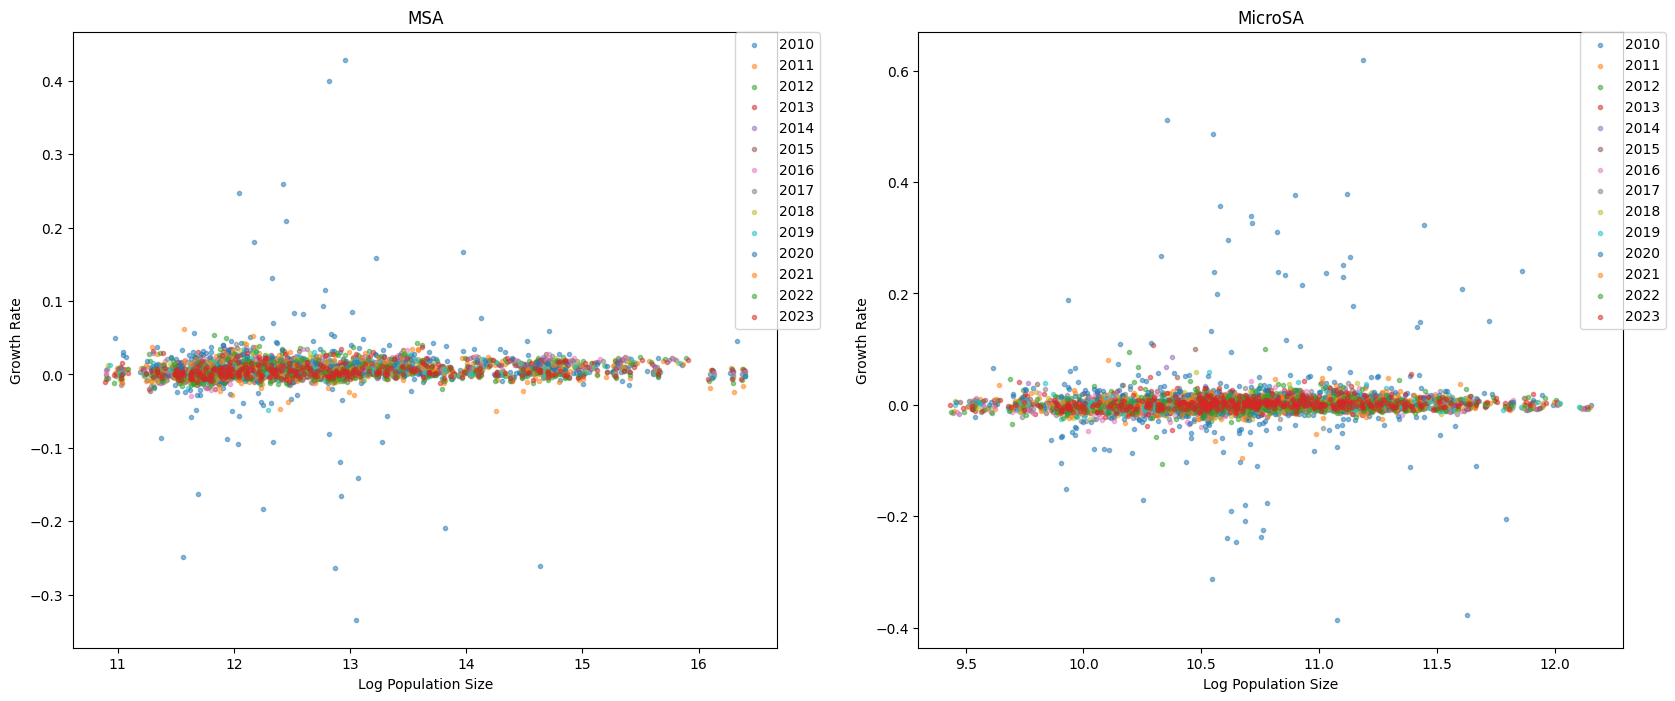

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) 
for i in range(14):
    if i <= 9:
        pop1 = met_growth.iloc[1:, 3+i]
        pop2 = mic_growth.iloc[2:, 3+i]
    else:
        pop1 = met_growth.iloc[1:, 4+i]
        pop2 = mic_growth.iloc[2:, 4+i]
    log_pop1 = np.log(pop1.astype(float))
    gr1 = met_growth.iloc[1:,18+i]
    ax1.scatter(log_pop1, gr1, label=str(2010+i), marker='.', alpha=0.5)
    log_pop2 = np.log(pop2.astype(float))
    gr2 = mic_growth.iloc[2:,18+i]
    ax2.scatter(log_pop2, gr2, label=str(2010+i), marker='.', alpha=0.5)

ax1.set_title('MSA')
ax1.set_xlabel('Log Population Size')
ax1.set_ylabel('Growth Rate')
ax1.legend(bbox_to_anchor=(1, 1), loc=9, borderaxespad=0)

ax2.set_title('MicroSA')
ax2.set_xlabel('Log Population Size')
ax2.set_ylabel('Growth Rate')
ax2.legend(bbox_to_anchor=(1, 1), loc=9, borderaxespad=0)

In [34]:
met_growth.rename(columns={'MetA':'name'},inplace=True)
mic_growth.rename(columns={'MicA':'name'},inplace=True)
cities = pd.concat([met_growth.iloc[1:, :],mic_growth.iloc[2:, :]])
cities

,name,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,...,2014GR,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR
1,".Abilene, TX Metro Area",165252,165252,165585,166634.0,167442.0,167473.0,168342.0,169688.0,170017.0,...,0.005189,0.007996,0.001939,0.002423,0.004231,0.005317,0.028031,0.005359,0.010313,0.010720
2,".Akron, OH Metro Area",703200,703196,703031,703200.0,702109.0,703621.0,704908.0,704382.0,703524.0,...,0.001829,-0.000746,-0.001218,0.000658,-0.000188,-0.000534,-0.002566,-0.007357,0.001434,0.001272
3,".Albany, GA Metro Area",153857,154033,154145,154545.0,153976.0,152667.0,151949.0,150387.0,149137.0,...,-0.004703,-0.010280,-0.008312,-0.007020,-0.001688,-0.007535,0.01038,-0.022368,0.005954,-0.001975
4,".Albany-Schenectady-Troy, NY Metro Area",870716,870713,871082,872778.0,874698.0,877065.0,878113.0,879085.0,879792.0,...,0.001195,0.001107,0.000804,0.002689,0.000119,-0.002133,0.021971,0.005668,-0.001358,0.001203
5,".Albuquerque, NM Metro Area",887077,887063,889558,898016.0,901939.0,904953.0,904538.0,906026.0,909237.0,...,-0.000459,0.001645,0.003544,0.003381,0.002889,0.003356,-0.000478,0.001976,0.000811,0.002345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,".Wooster, OH Micro Area",114520,114516,114394,114649.0,115029.0,115400.0,115912.0,116214.0,116613.0,...,0.004437,0.002605,0.003433,-0.003816,-0.003254,-0.000691,0.010483,-0.006397,0.003245,-0.000360
474,".Worthington, MN Micro Area",21378,21378,21425,21621.0,21736.0,21797.0,21698.0,21748.0,21878.0,...,-0.004542,0.002304,0.005978,-0.009462,0.003369,-0.005289,0.026631,-0.00608,-0.005075,-0.010520
475,".Yankton, SD Micro Area",22438,22438,22436,22500.0,22584.0,22641.0,22676.0,22682.0,22649.0,...,0.001546,0.000265,-0.001455,0.001457,0.003395,0.002417,0.020689,0.002877,0.002526,0.004485
476,".Zanesville, OH Micro Area",86074,86086,86214,86243.0,85794.0,85649.0,85905.0,86194.0,85993.0,...,0.002989,0.003364,-0.002332,0.001512,0.000093,0.000975,0.002935,0.001261,-0.005348,0.002218


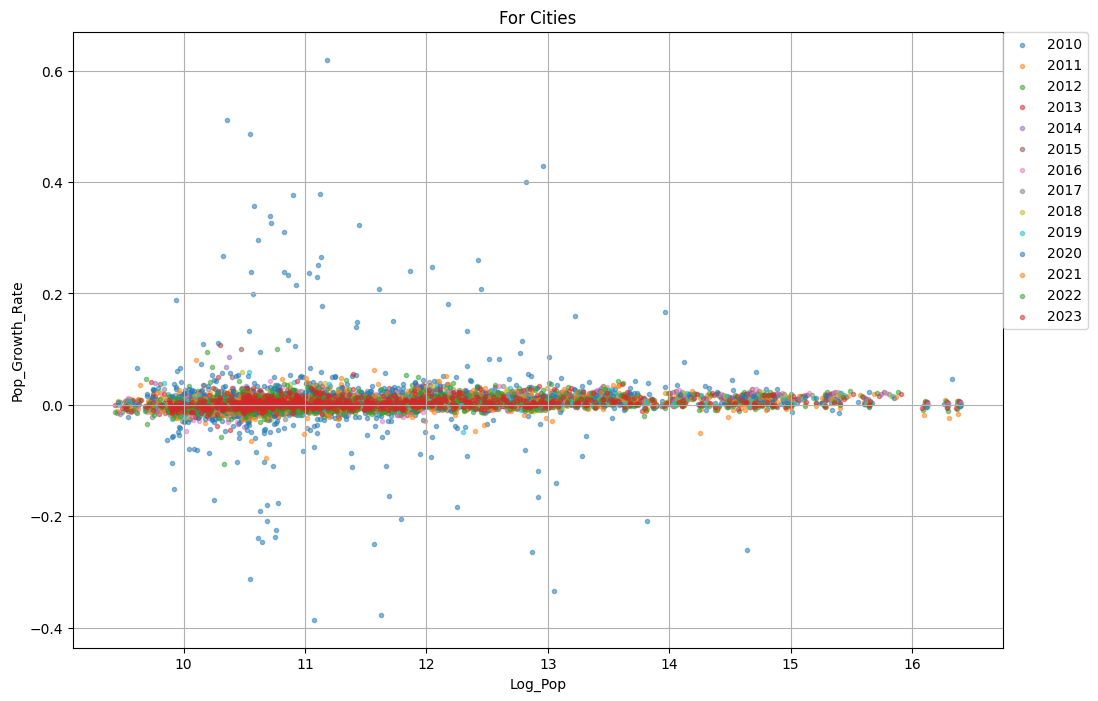

In [35]:
plt.figure(figsize=(12, 8)) 
for i in range(14):
    if i <= 9:
        pop = cities.iloc[:, 3+i]
    else:
        pop = cities.iloc[:, 4+i]
    log_pop = np.log(pop.astype(float))
    gr = cities.iloc[:,18+i]
    plt.scatter(log_pop, gr, label=str(2010+i), marker='.', alpha=0.5)
plt.xlabel('Log_Pop')
plt.ylabel('Pop_Growth_Rate')
plt.title('For Cities')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0)
plt.grid(True)
plt.show()

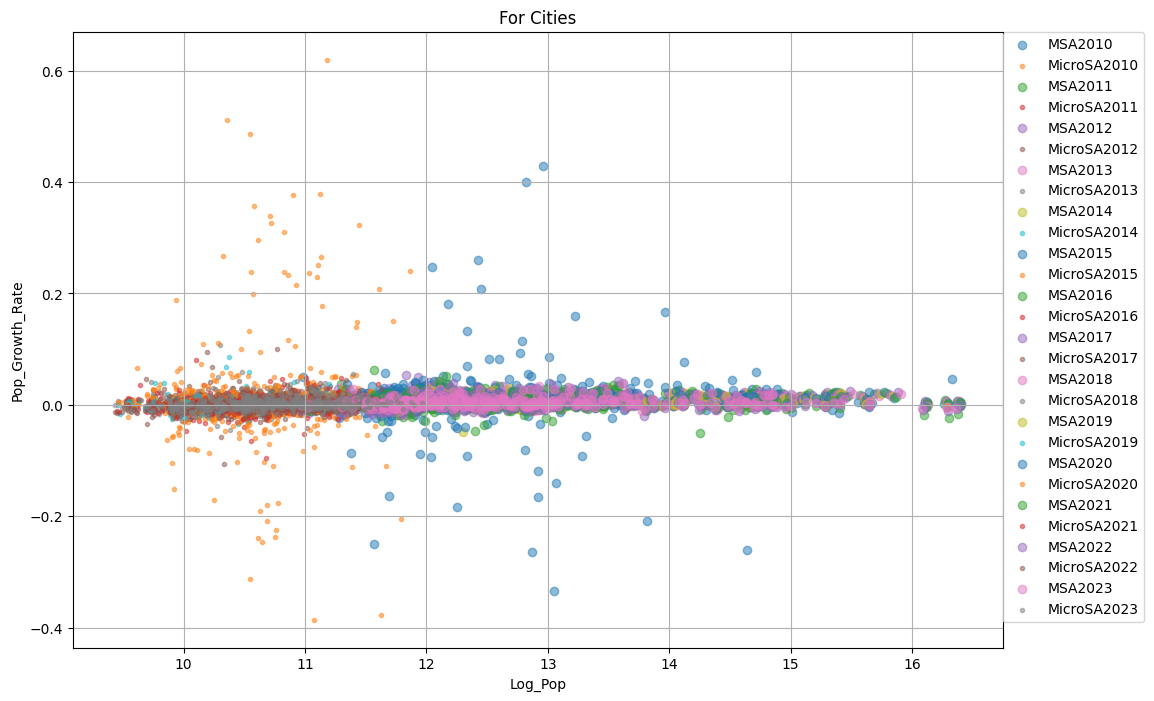

In [36]:
plt.figure(figsize=(12, 8)) 
for i in range(14):
    if i <= 9:
        pop1 = met_growth.iloc[2:, 3+i]
        pop2 = mic_growth.iloc[2:, 3+i]
    else:
        pop1 = met_growth.iloc[2:, 4+i]
        pop2 = mic_growth.iloc[2:, 4+i]
    log_pop1 = np.log(pop1.astype(float))
    log_pop2 = np.log(pop2.astype(float))
    gr1 = met_growth.iloc[2:,18+i]
    gr2 = mic_growth.iloc[2:,18+i]
    plt.scatter(log_pop1, gr1, label='MSA'+str(2010+i), marker='o', alpha=0.5)
    plt.scatter(log_pop2, gr2, label='MicroSA'+str(2010+i), marker='.', alpha=0.5)
plt.xlabel('Log_Pop')
plt.ylabel('Pop_Growth_Rate')
plt.title('For Cities')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0)
plt.grid(True)
plt.show()

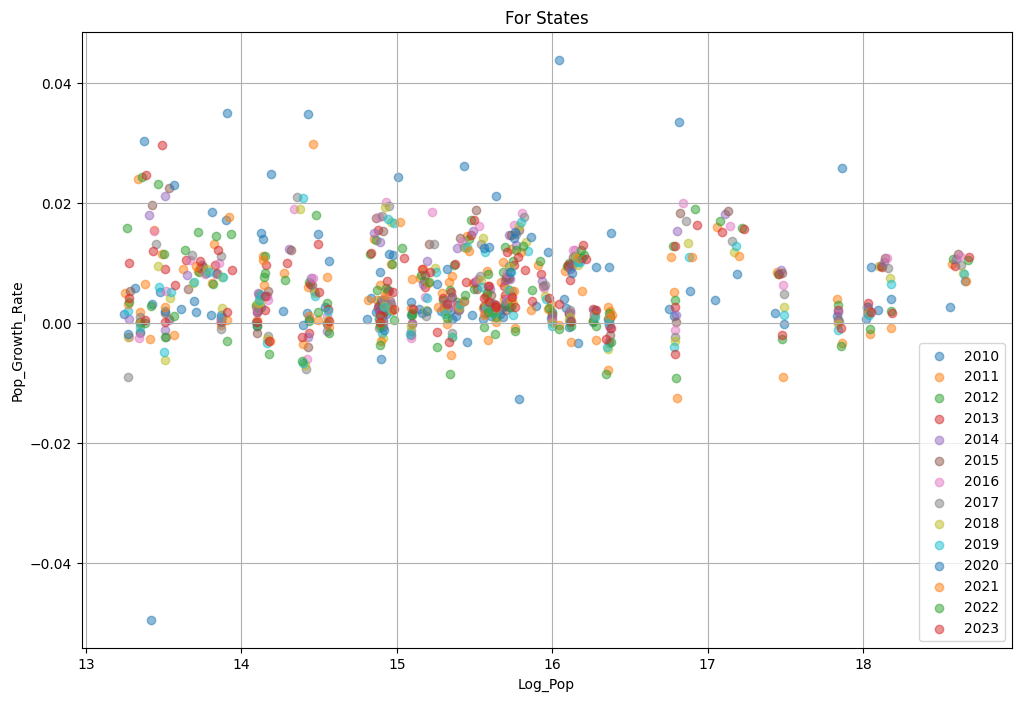

In [37]:
plt.figure(figsize=(12, 8)) 
for i in range(14):
    if i <= 9:
        pop = nst_growth.iloc[1:,3+i]
    else:
        pop = nst_growth.iloc[1:,4+i]
    log_pop = np.log(pop.astype(float))
    gr = nst_growth.iloc[1:,18+i]
    plt.scatter(log_pop, gr, label=str(2010+i), marker='o', alpha=0.5)
plt.xlabel('Log_Pop')
plt.ylabel('Pop_Growth_Rate')
plt.title('For States')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
cities1 = cities.copy()
cities1['name'] = cities1['name'].str.replace('Metro Area', '', regex=False)
cities1['name'] = cities1['name'].str.replace('Micro Area', '', regex=False)

In [39]:
cities1['state'] = cities1['name'].str.split(',',1).str[1]
cities1.state.unique()

array([' TX ', ' OH ', ' GA ', ' NY ', ' NM ', ' LA ', ' PA-NJ ', ' PA ',
       ' IA ', ' AK ', ' MI ', ' AL ', ' WI ', ' NC ', ' NJ ', ' GA-SC ',
       ' MD ', ' ME ', ' MA ', ' WV ', ' WA ', ' OR ', ' MT ', ' ND ',
       ' IL ', ' IN ', ' ID ', ' MA-NH ', ' MA Metro Division',
       ' NH Metro Division', ' CO ', ' KY ', ' VT ', ' FL ', ' MO-IL ',
       ' NV ', ' WY ', ' SC ', ' NC-SC ', ' VA ', ' TN-GA ',
       ' IL Metro Division', ' CA ', ' OH-KY-IN ', ' TN-KY ', ' TN ',
       ' MO ', ' GA-AL ', ' TX Metro Division', ' IA-IL ',
       ' MI Metro Division', ' DE ', ' MN-WI ', ' OK ', ' ND-MN ', ' AR ',
       ' AZ ', ' AR-OK ', ' NE ', ' MS ', ' MD-WV ', ' WV-KY-OH ',
       ' MO-KS ', ' TN-VA ', ' WI-MN ', ' KS ', ' ID-WA ', ' UT-ID ',
       ' CA Metro Division', ' KY-IN ', ' NH ', ' MN ', ' TN-MS-AR ',
       ' FL Metro Division', ' NY Metro Division',
       ' NY-NJ Metro Division', ' PA-NJ-DE-MD ', ' NJ Metro Division',
       ' PA Metro Division', ' DE-MD-NJ Metro Divis

In [40]:
cities1

,name,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,...,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR,state
1,".Abilene, TX",165252,165252,165585,166634.0,167442.0,167473.0,168342.0,169688.0,170017.0,...,0.007996,0.001939,0.002423,0.004231,0.005317,0.028031,0.005359,0.010313,0.010720,TX
2,".Akron, OH",703200,703196,703031,703200.0,702109.0,703621.0,704908.0,704382.0,703524.0,...,-0.000746,-0.001218,0.000658,-0.000188,-0.000534,-0.002566,-0.007357,0.001434,0.001272,OH
3,".Albany, GA",153857,154033,154145,154545.0,153976.0,152667.0,151949.0,150387.0,149137.0,...,-0.010280,-0.008312,-0.007020,-0.001688,-0.007535,0.01038,-0.022368,0.005954,-0.001975,GA
4,".Albany-Schenectady-Troy, NY",870716,870713,871082,872778.0,874698.0,877065.0,878113.0,879085.0,879792.0,...,0.001107,0.000804,0.002689,0.000119,-0.002133,0.021971,0.005668,-0.001358,0.001203,NY
5,".Albuquerque, NM",887077,887063,889558,898016.0,901939.0,904953.0,904538.0,906026.0,909237.0,...,0.001645,0.003544,0.003381,0.002889,0.003356,-0.000478,0.001976,0.000811,0.002345,NM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,".Wooster, OH",114520,114516,114394,114649.0,115029.0,115400.0,115912.0,116214.0,116613.0,...,0.002605,0.003433,-0.003816,-0.003254,-0.000691,0.010483,-0.006397,0.003245,-0.000360,OH
474,".Worthington, MN",21378,21378,21425,21621.0,21736.0,21797.0,21698.0,21748.0,21878.0,...,0.002304,0.005978,-0.009462,0.003369,-0.005289,0.026631,-0.00608,-0.005075,-0.010520,MN
475,".Yankton, SD",22438,22438,22436,22500.0,22584.0,22641.0,22676.0,22682.0,22649.0,...,0.000265,-0.001455,0.001457,0.003395,0.002417,0.020689,0.002877,0.002526,0.004485,SD
476,".Zanesville, OH",86074,86086,86214,86243.0,85794.0,85649.0,85905.0,86194.0,85993.0,...,0.003364,-0.002332,0.001512,0.000093,0.000975,0.002935,0.001261,-0.005348,0.002218,OH


In [41]:
md = list(cities1[cities1['state'].str.contains('Metro Division')]['name'])

In [42]:
hi = list(cities1[cities1['state'].str.contains('HI')]['name'])

In [43]:
o = list(cities1['name'])

In [46]:
for state in o:
    if state in md:
        o.remove(state)
    elif state in hi:
        o.remove(state)

In [47]:
cities1 = cities1[cities1['name'].isin(o)]
cities1

,name,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,...,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR,state
1,".Abilene, TX",165252,165252,165585,166634.0,167442.0,167473.0,168342.0,169688.0,170017.0,...,0.007996,0.001939,0.002423,0.004231,0.005317,0.028031,0.005359,0.010313,0.010720,TX
2,".Akron, OH",703200,703196,703031,703200.0,702109.0,703621.0,704908.0,704382.0,703524.0,...,-0.000746,-0.001218,0.000658,-0.000188,-0.000534,-0.002566,-0.007357,0.001434,0.001272,OH
3,".Albany, GA",153857,154033,154145,154545.0,153976.0,152667.0,151949.0,150387.0,149137.0,...,-0.010280,-0.008312,-0.007020,-0.001688,-0.007535,0.01038,-0.022368,0.005954,-0.001975,GA
4,".Albany-Schenectady-Troy, NY",870716,870713,871082,872778.0,874698.0,877065.0,878113.0,879085.0,879792.0,...,0.001107,0.000804,0.002689,0.000119,-0.002133,0.021971,0.005668,-0.001358,0.001203,NY
5,".Albuquerque, NM",887077,887063,889558,898016.0,901939.0,904953.0,904538.0,906026.0,909237.0,...,0.001645,0.003544,0.003381,0.002889,0.003356,-0.000478,0.001976,0.000811,0.002345,NM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,".Wooster, OH",114520,114516,114394,114649.0,115029.0,115400.0,115912.0,116214.0,116613.0,...,0.002605,0.003433,-0.003816,-0.003254,-0.000691,0.010483,-0.006397,0.003245,-0.000360,OH
474,".Worthington, MN",21378,21378,21425,21621.0,21736.0,21797.0,21698.0,21748.0,21878.0,...,0.002304,0.005978,-0.009462,0.003369,-0.005289,0.026631,-0.00608,-0.005075,-0.010520,MN
475,".Yankton, SD",22438,22438,22436,22500.0,22584.0,22641.0,22676.0,22682.0,22649.0,...,0.000265,-0.001455,0.001457,0.003395,0.002417,0.020689,0.002877,0.002526,0.004485,SD
476,".Zanesville, OH",86074,86086,86214,86243.0,85794.0,85649.0,85905.0,86194.0,85993.0,...,0.003364,-0.002332,0.001512,0.000093,0.000975,0.002935,0.001261,-0.005348,0.002218,OH


In [48]:
cities1.iloc[:,19:-1]

,2011GR,2012GR,2013GR,2014GR,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR
1,0.006335,0.004849,0.000185,0.005189,0.007996,0.001939,0.002423,0.004231,0.005317,0.028031,0.005359,0.010313,0.010720
2,0.00024,-0.001551,0.002154,0.001829,-0.000746,-0.001218,0.000658,-0.000188,-0.000534,-0.002566,-0.007357,0.001434,0.001272
3,0.002595,-0.003682,-0.008501,-0.004703,-0.010280,-0.008312,-0.007020,-0.001688,-0.007535,0.01038,-0.022368,0.005954,-0.001975
4,0.001947,0.002200,0.002706,0.001195,0.001107,0.000804,0.002689,0.000119,-0.002133,0.021971,0.005668,-0.001358,0.001203
5,0.009508,0.004369,0.003342,-0.000459,0.001645,0.003544,0.003381,0.002889,0.003356,-0.000478,0.001976,0.000811,0.002345
...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,0.002229,0.003314,0.003225,0.004437,0.002605,0.003433,-0.003816,-0.003254,-0.000691,0.010483,-0.006397,0.003245,-0.000360
474,0.009148,0.005319,0.002806,-0.004542,0.002304,0.005978,-0.009462,0.003369,-0.005289,0.026631,-0.00608,-0.005075,-0.010520
475,0.002853,0.003733,0.002524,0.001546,0.000265,-0.001455,0.001457,0.003395,0.002417,0.020689,0.002877,0.002526,0.004485
476,0.000336,-0.005206,-0.001690,0.002989,0.003364,-0.002332,0.001512,0.000093,0.000975,0.002935,0.001261,-0.005348,0.002218


In [53]:
X = np.log(cities1.iloc[:,np.r_[4:13,14:18]].astype(float)).values.reshape(-1, 1)
y_cities = cities1.iloc[:,19:-1].astype(float).values.reshape(-1, 1)
X_cities = sm.add_constant(X)

In [54]:
model_cities = sm.OLS(y_cities, X_cities)
result = model_cities.fit()
'''city_params = model_cities.params
city_pvalues = model_cities.pvalues
city_conf_int = model_cities.conf_int(alpha=0.05)  # 95% confidence interval'''

'city_params = model_cities.params\ncity_pvalues = model_cities.pvalues\ncity_conf_int = model_cities.conf_int(alpha=0.05)  # 95% confidence interval'

In [55]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     131.3
Date:                Mon, 13 May 2024   Prob (F-statistic):           3.26e-30
Time:                        16:25:41   Log-Likelihood:                 23742.
No. Observations:               10296   AIC:                        -4.748e+04
Df Residuals:                   10294   BIC:                        -4.746e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0233      0.002    -10.095      0.0

In [68]:
model_cities1 = LinearRegression()
model_cities1.fit(X, y_cities)

LinearRegression()

In [69]:
city_params=model_cities1.coef_

In [70]:
city_intercept=model_cities1.intercept_

In [71]:
import scipy.stats as stats

In [72]:
city_params_ci = stats.t.interval(0.95, df=len(X)-2, loc=city_params, scale=model_cities1.coef_/np.sqrt(len(X)))
city_intercept_ci = stats.t.interval(0.95, df=len(X)-2, loc=city_intercept, scale=model_cities1.intercept_/np.sqrt(len(X)))

In [73]:
predictions_cities = model_cities1.predict(X)

In [74]:
mse_cities = mean_squared_error(y_cities, predictions_cities)
r2_cities = r2_score(y_cities, predictions_cities)

In [80]:
print("For cities:")
print("Mean Squared Error:", mse_cities)
print("R-squared:", r2_cities)
print('95% CI:',city_params_ci[0],city_params_ci[1])

For cities:
Mean Squared Error: 0.0005816251881083991
R-squared: 0.012593556846111409
95% CI: [[0.00224534]] [[0.0023338]]


In [76]:
n_cities = len(X_cities)
mse_cities = mean_squared_error(y_cities, predictions_cities)
se_cities = np.sqrt(np.diag(np.linalg.inv(np.dot(X.T, X)) * mse_cities / (n_cities - 2)))

# Calculate t-score for 95% confidence interval (two-tailed)
t_score_cities = stats.t.ppf(0.975, n_cities - 2)

# Compute confidence intervals
ci_cities = np.column_stack((model_cities1.coef_ - t_score_cities * se_cities, 
                             model_cities1.coef_ + t_score_cities * se_cities))
print("Confidence Intervals for cities:")
print(ci_cities)

Confidence Intervals for cities:
[[0.00228917 0.00228997]]


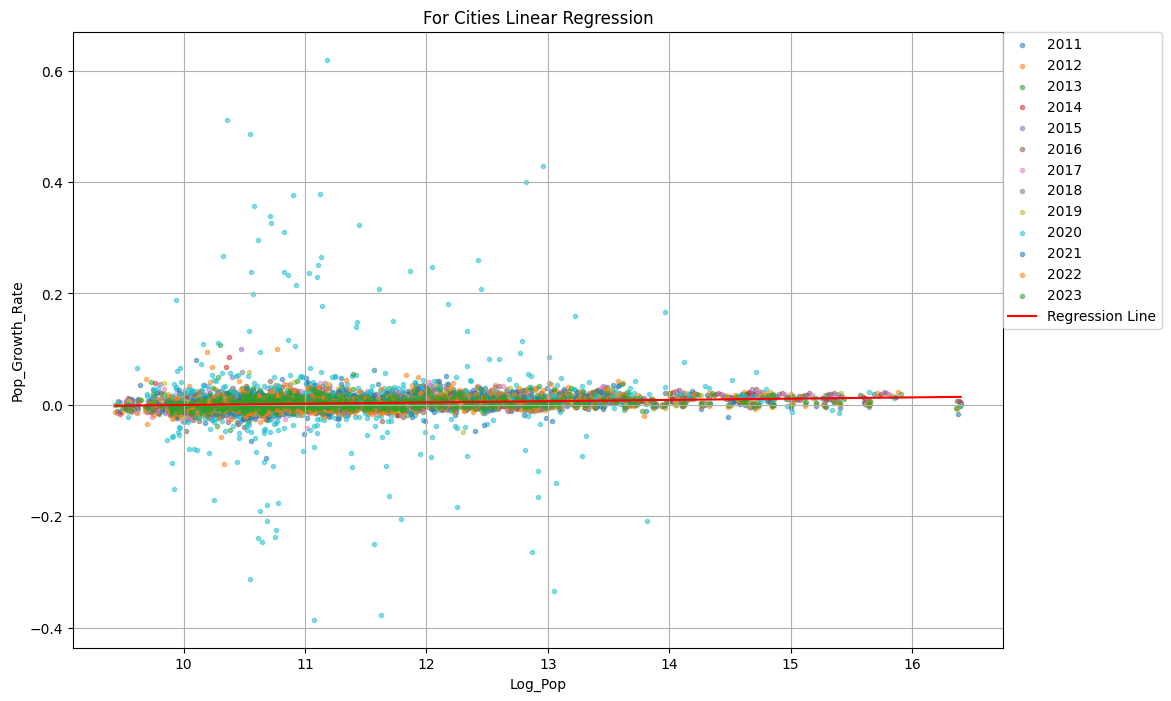

In [165]:
plt.figure(figsize=(12, 8)) 
for i in range(13):
    if i <= 8:
        pop = cities1.iloc[:, 4+i]
    else:
        pop = cities1.iloc[:, 5+i]
    log_pop = np.log(pop.astype(float))
    gr = cities1.iloc[:,19+i]
    plt.scatter(log_pop, gr, label=str(2011+i), marker='.', alpha=0.5)
    
x_values = np.linspace(X.min(), X.max(), 100)
y_values = result.params[0] + result.params[1] * x_values
plt.plot(x_values, y_values, color='red', label='Regression Line')

plt.xlabel('Log_Pop')
plt.ylabel('Pop_Growth_Rate')
plt.title('For Cities Linear Regression')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0)
plt.grid(True)
plt.show()

In [167]:
states=nst_growth.copy()
states = states[(states['states'] != '.Hawaii') & (states['states'] != '.District of Columbia')]
states=states.iloc[5:,:]
len(states)

49

In [168]:
states

,states,Census,Estimates Base_x,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,...,2014GR,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR
5,.Alabama,4779736,4780125,4785437,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,...,0.002426,0.002179,0.002304,0.002254,0.002707,0.003172,0.026244,0.00368,0.004658,0.006812
6,.Alaska,710231,710249,713910,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,...,-0.001065,0.001650,0.005367,-0.002368,-0.006166,-0.004889,0.00194,0.002673,-0.002241,0.000177
7,.Arizona,6392017,6392288,6407172,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,...,0.014722,0.014748,0.016311,0.014830,0.016186,0.016861,-0.012644,0.011939,0.012815,0.008914
8,.Arkansas,2915918,2916031,2921964,2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,...,0.002701,0.003591,0.003986,0.003822,0.002795,0.002682,-0.001145,0.004676,0.005931,0.007001
9,.California,37253956,37254519,37319502,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,...,0.008787,0.008319,0.006400,0.004886,0.002619,0.001283,-0.000228,-0.009066,-0.002668,-0.001932
10,.Colorado,5029196,5029319,5047349,5121108.0,5192647.0,5269035.0,5350101.0,5450623.0,5539215.0,...,0.015385,0.018789,0.016254,0.013119,0.014149,0.011851,0.004599,0.004559,0.005066,0.006261
11,.Connecticut,3574097,3574147,3579114,3588283.0,3594547.0,3594841.0,3594524.0,3587122.0,3578141.0,...,-0.000088,-0.002059,-0.002504,-0.001354,-0.000497,-0.001745,0.00345,0.007297,0.001392,0.002347
12,.Delaware,897934,897937,899593,907381.0,915179.0,923576.0,932487.0,941252.0,948921.0,...,0.009648,0.009400,0.008148,0.008327,0.009047,0.008581,0.018586,0.013126,0.014507,0.012194
14,.Florida,18801310,18804564,18845537,19053237.0,19297822.0,19545621.0,19845911.0,20209042.0,20613477.0,...,0.015364,0.018298,0.020013,0.016986,0.013390,0.010987,0.005287,0.011088,0.019001,0.016417
15,.Georgia,9687653,9688729,9711881,9802431.0,9901430.0,9972479.0,10067278.0,10178447.0,10301890.0,...,0.009506,0.011043,0.012128,0.010526,0.009683,0.010112,0.010828,0.005404,0.011377,0.010636


In [169]:
states.iloc[:,19:]

,2011GR,2012GR,2013GR,2014GR,2015GR,2016GR,2017GR,2018GR,2019GR,2020GR,2021GR,2022GR,2023GR
5,0.002849,0.003442,0.003010,0.002426,0.002179,0.002304,0.002254,0.002707,0.003172,0.026244,0.00368,0.004658,0.006812
6,0.011511,0.011515,0.009070,-0.001065,0.001650,0.005367,-0.002368,-0.006166,-0.004889,0.00194,0.002673,-0.002241,0.000177
7,0.010218,0.012720,0.011867,0.014722,0.014748,0.016311,0.014830,0.016186,0.016861,-0.012644,0.011939,0.012815,0.008914
8,0.006401,0.003910,0.002451,0.002701,0.003591,0.003986,0.003822,0.002795,0.002682,-0.001145,0.004676,0.005931,0.007001
9,0.008544,0.008248,0.008221,0.008787,0.008319,0.006400,0.004886,0.002619,0.001283,-0.000228,-0.009066,-0.002668,-0.001932
10,0.014613,0.013969,0.014711,0.015385,0.018789,0.016254,0.013119,0.014149,0.011851,0.004599,0.004559,0.005066,0.006261
11,0.002562,0.001746,0.000082,-0.000088,-0.002059,-0.002504,-0.001354,-0.000497,-0.001745,0.00345,0.007297,0.001392,0.002347
12,0.008657,0.008594,0.009175,0.009648,0.009400,0.008148,0.008327,0.009047,0.008581,0.018586,0.013126,0.014507,0.012194
14,0.011021,0.012837,0.012841,0.015364,0.018298,0.020013,0.016986,0.013390,0.010987,0.005287,0.011088,0.019001,0.016417
15,0.009324,0.010099,0.007176,0.009506,0.011043,0.012128,0.010526,0.009683,0.010112,0.010828,0.005404,0.011377,0.010636


In [170]:
states.iloc[:,np.r_[4:13,14:18]]

,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020,2021.0,2022.0,2023.0
5,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0,5031864,5050380.0,5073903.0,5108468.0
6,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0,732964,734923.0,733276.0,733406.0
7,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0,7186683,7272487.0,7365684.0,7431344.0
8,2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0,3014348,3028443.0,3046404.0,3067732.0
9,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0,39503200,39145060.0,39040616.0,38965193.0
10,5121108.0,5192647.0,5269035.0,5350101.0,5450623.0,5539215.0,5611885.0,5691287.0,5758736.0,5785219,5811596.0,5841039.0,5877610.0
11,3588283.0,3594547.0,3594841.0,3594524.0,3587122.0,3578141.0,3573297.0,3571520.0,3565287.0,3577586,3603691.0,3608706.0,3617176.0
12,907381.0,915179.0,923576.0,932487.0,941252.0,948921.0,956823.0,965479.0,973764.0,991862,1004881.0,1019459.0,1031890.0
14,19053237.0,19297822.0,19545621.0,19845911.0,20209042.0,20613477.0,20963613.0,21244317.0,21477737.0,21591299,21830708.0,22245521.0,22610726.0
15,9802431.0,9901430.0,9972479.0,10067278.0,10178447.0,10301890.0,10410330.0,10511131.0,10617423.0,10732390,10790385.0,10913150.0,11029227.0


In [171]:
X2 = np.log(states.iloc[:,np.r_[4:13,14:18]].astype(float)).values.reshape(-1, 1)
y_states = states.iloc[:,19:].astype(float).values.reshape(-1, 1)
X_states = sm.add_constant(X2)

In [172]:
model_states = sm.OLS(y_states, X_states)
results = model_states.fit()

In [173]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1408
Date:                Mon, 13 May 2024   Prob (F-statistic):              0.708
Time:                        17:02:54   Log-Likelihood:                 2259.6
No. Observations:                 637   AIC:                            -4515.
Df Residuals:                     635   BIC:                            -4506.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.044      0.2

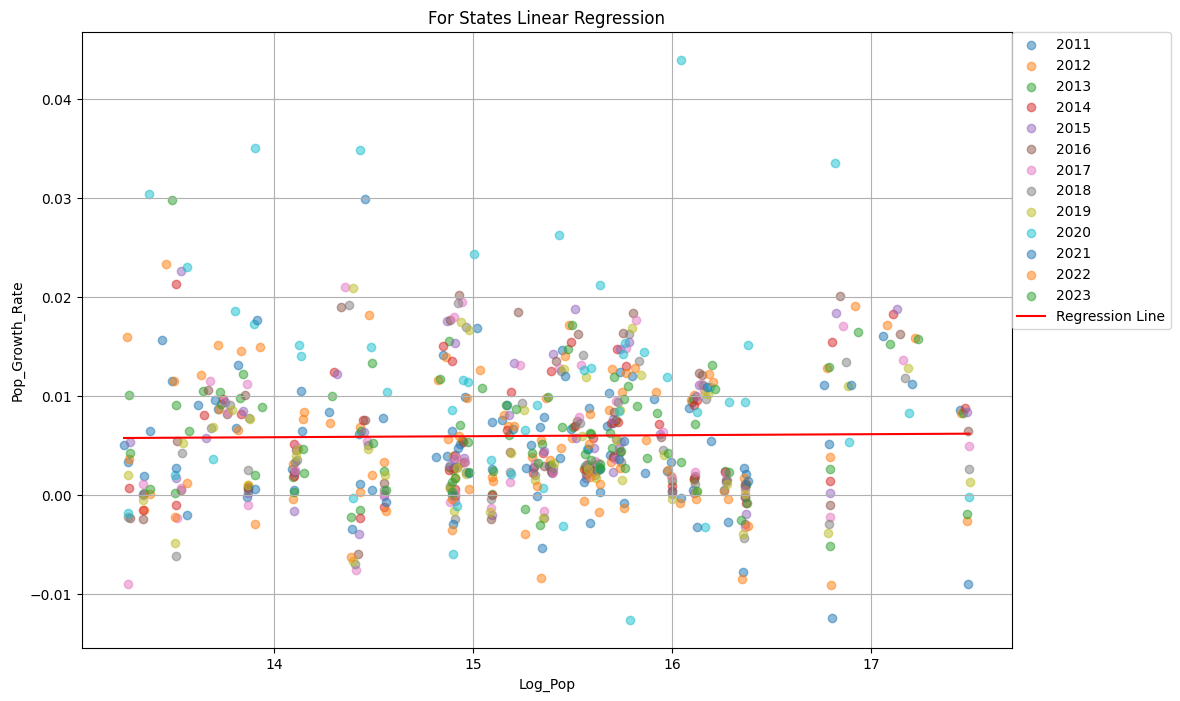

In [175]:
plt.figure(figsize=(12, 8)) 
for i in range(13):
    if i <= 8:
        pop = states.iloc[:, 4+i]
    else:
        pop = states.iloc[:, 5+i]
    log_pop = np.log(pop.astype(float))
    gr = states.iloc[:,19+i]
    plt.scatter(log_pop, gr, label=str(2011+i), marker='o', alpha=0.5)
    
x_values = np.linspace(X2.min(), X2.max(), 100)
y_values = results.params[0] + results.params[1] * x_values
plt.plot(x_values, y_values, color='red', label='Regression Line')

plt.xlabel('Log_Pop')
plt.ylabel('Pop_Growth_Rate')
plt.title('For States Linear Regression')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0)
plt.grid(True)
plt.show()

### Problem 3

In [176]:
data = pd.read_csv('time_series_covid19_confirmed_US.csv')

In [177]:
data

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,12130,12130,12130,12130,12130,12130,12130,12134,12134,12134
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,6401,6401,6401,6401,6401,6401,6401,6406,6406,6406
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,2750,2750,2750,2750,2750,2750,2750,2755,2755,2755


In [178]:
print(data[data['Province_State']=='New York']['Admin2'].unique())

['Albany' 'Allegany' 'Bronx' 'Broome' 'Cattaraugus' 'Cayuga' 'Chautauqua'
 'Chemung' 'Chenango' 'Clinton' 'Columbia' 'Cortland' 'Delaware'
 'Dutchess' 'Erie' 'Essex' 'Franklin' 'Fulton' 'Genesee' 'Greene'
 'Hamilton' 'Herkimer' 'Jefferson' 'Kings' 'Lewis' 'Livingston' 'Madison'
 'Monroe' 'Montgomery' 'Nassau' 'New York' 'Niagara' 'Oneida' 'Onondaga'
 'Ontario' 'Orange' 'Orleans' 'Oswego' 'Otsego' 'Out of NY' 'Putnam'
 'Queens' 'Rensselaer' 'Richmond' 'Rockland' 'Saratoga' 'Schenectady'
 'Schoharie' 'Schuyler' 'Seneca' 'St. Lawrence' 'Steuben' 'Suffolk'
 'Sullivan' 'Tioga' 'Tompkins' 'Ulster' 'Unassigned' 'Warren' 'Washington'
 'Wayne' 'Westchester' 'Wyoming' 'Yates']


In [179]:
target = ['New York','Kings','Los Angeles']

In [180]:
ndata = data[data['Admin2'].isin(target)]
ndata

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
212,84006031,US,USA,840,6031.0,Kings,California,US,36.074091,-119.815997,...,67291,67291,67291,67291,67291,67291,67291,67356,67356,67356
215,84006037,US,USA,840,6037.0,Los Angeles,California,US,34.308284,-118.228241,...,3697797,3697797,3704034,3705381,3705381,3705381,3705381,3705381,3705381,3710586
1925,84036047,US,USA,840,36047.0,Kings,New York,US,40.636182,-73.949356,...,962267,962377,962682,962890,962890,962890,963390,963488,963672,963672
1932,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,...,595118,595203,595458,595628,595628,595628,596044,596132,596196,596334


In [181]:
ndata = ndata.iloc[1:,:]
ndata

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
215,84006037,US,USA,840,6037.0,Los Angeles,California,US,34.308284,-118.228241,...,3697797,3697797,3704034,3705381,3705381,3705381,3705381,3705381,3705381,3710586
1925,84036047,US,USA,840,36047.0,Kings,New York,US,40.636182,-73.949356,...,962267,962377,962682,962890,962890,962890,963390,963488,963672,963672
1932,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,...,595118,595203,595458,595628,595628,595628,596044,596132,596196,596334


In [182]:
NY_data = ndata[ndata['Admin2']=='New York']
BK_data = ndata[ndata['Admin2']=='Kings']
LA_data = ndata[ndata['Admin2']=='Los Angeles']

In [183]:
NY = NY_data.iloc[:,11:].sum()
#NY = NY.reset_index()
#NY.rename(columns={'index':'date',0:'n'},inplace=True)

In [184]:
BK = BK_data.iloc[:,11:].sum()
#BK = BK.reset_index()
#BK.rename(columns={'index':'date',0:'n'},inplace=True)

In [185]:
LA = LA_data.iloc[:,11:].sum()
#LA = LA.reset_index()
#LA.rename(columns={'index':'date',0:'n'},inplace=True)

In [22]:
'''
NY['pop'] = 1600000
BK['pop'] = 2600000
LA['pop'] = 9700000'''

"\nNY['pop'] = 1600000\nBK['pop'] = 2600000\nLA['pop'] = 9700000"

In [196]:
NY

1/22/20         0
1/23/20         0
1/24/20         0
1/25/20         0
1/26/20         0
            ...  
3/5/23     595628
3/6/23     596044
3/7/23     596132
3/8/23     596196
3/9/23     596334
Length: 1143, dtype: int64

In [198]:
BK

1/22/20         0
1/23/20         0
1/24/20         0
1/25/20         0
1/26/20         0
            ...  
3/5/23     962890
3/6/23     963390
3/7/23     963488
3/8/23     963672
3/9/23     963672
Length: 1143, dtype: int64

In [188]:
LA

1/22/20          0
1/23/20          0
1/24/20          0
1/25/20          0
1/26/20          1
            ...   
3/5/23     3705381
3/6/23     3705381
3/7/23     3705381
3/8/23     3705381
3/9/23     3710586
Length: 1143, dtype: int64

In [215]:
a=NY.reset_index()
Timeline = a['index']
Timeline

0       1/22/20
1       1/23/20
2       1/24/20
3       1/25/20
4       1/26/20
         ...   
1138     3/5/23
1139     3/6/23
1140     3/7/23
1141     3/8/23
1142     3/9/23
Name: index, Length: 1143, dtype: object

In [236]:
NY.values

array([     0,      0,      0, ..., 596132, 596196, 596334], dtype=int64)

In [253]:
mse([0.2, 0.1, 1e-6],days, NY.values, population_manhattan)

101076304753.17323

In [263]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime

# SIR模型微分方程，包括新增的T(t)方程
def sir_model(y, t, beta, gamma):
    S, I, R, T = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    dT_dt = beta * S * I
    return [dS_dt, dI_dt, dR_dt, dT_dt]

# 定义误差函数
def mse(params, t, actual_cases, population):
    beta, gamma, I0 = params
    S0 = 1 - I0
    R0 = 0
    T0 = actual_cases[0] / population
    initial_conditions = [S0, I0, R0, T0]

    solution = odeint(sir_model, initial_conditions, t, args=(beta, gamma))
    T = solution[:, 3] * population
    mse = np.mean((T - actual_cases)**2)
    return mse

# 优化参数
def optimize_params(t, actual_cases, population):
    initial_guess = [1, 1, 1/population]
    result = minimize(mse, initial_guess, args=(t, actual_cases, population), bounds=[(0, 1), (0, 1), (1/population, 1)])
    beta_opt, gamma_opt, I0_opt = result.x
    return beta_opt, gamma_opt, I0_opt, result.fun

# 定义时间范围和人口
start_date = datetime.date(2020, 1, 22)
end_date = datetime.date(2023, 3, 9)  # 假设数据截止到2023年3月9日
days = [(d.date() - start_date).days for d in pd.date_range(start_date, end_date)]
#days = pd.to_datetime(Timeline).dt.days.values
population_manhattan = 1.6e6
population_brooklyn = 2.6e6
population_la = 9.7e6

# 优化参数并计算均方误差
beta_manhattan, gamma_manhattan, I0_manhattan, mse_manhattan = optimize_params(days, NY.values, population_manhattan)
beta_brooklyn, gamma_brooklyn, I0_brooklyn, mse_brooklyn = optimize_params(days, BK.values, population_brooklyn)
beta_la, gamma_la, I0_la, mse_la = optimize_params(days, LA.values, population_la)

# 输出结果
print(f"Manhattan: beta={beta_manhattan}, gamma={gamma_manhattan}, I0={I0_manhattan}, MSE={mse_manhattan}")
print(f"Brooklyn: beta={beta_brooklyn}, gamma={gamma_brooklyn}, I0={I0_brooklyn}, MSE={mse_brooklyn}")
print(f"Los Angeles: beta={beta_la}, gamma={gamma_la}, I0={I0_la}, MSE={mse_la}")

# 计算并绘制最优参数下的预测结果
solution_manhattan = odeint(sir_model, [1-I0_manhattan, I0_manhattan, 0, NY[0]/population_manhattan], days, args=(beta_manhattan, gamma_manhattan))
solution_brooklyn = odeint(sir_model, [1-I0_brooklyn, I0_brooklyn, 0, BK[0]/population_brooklyn], days, args=(beta_brooklyn, gamma_brooklyn))
solution_la = odeint(sir_model, [1-I0_la, I0_la, 0, LA[0]/population_la], days, args=(beta_la, gamma_la))


Manhattan: beta=0.026871767811493776, gamma=0.02066851785119316, I0=0.0009831750074183639, MSE=894042942.7954944
Brooklyn: beta=0.02073592142196281, gamma=0.015766308553195853, I0=0.0026848722038824474, MSE=2094590791.8632872
Los Angeles: beta=0.01613907934019789, gamma=0.011902437455612518, I0=0.00566055610976813, MSE=42487360618.05614


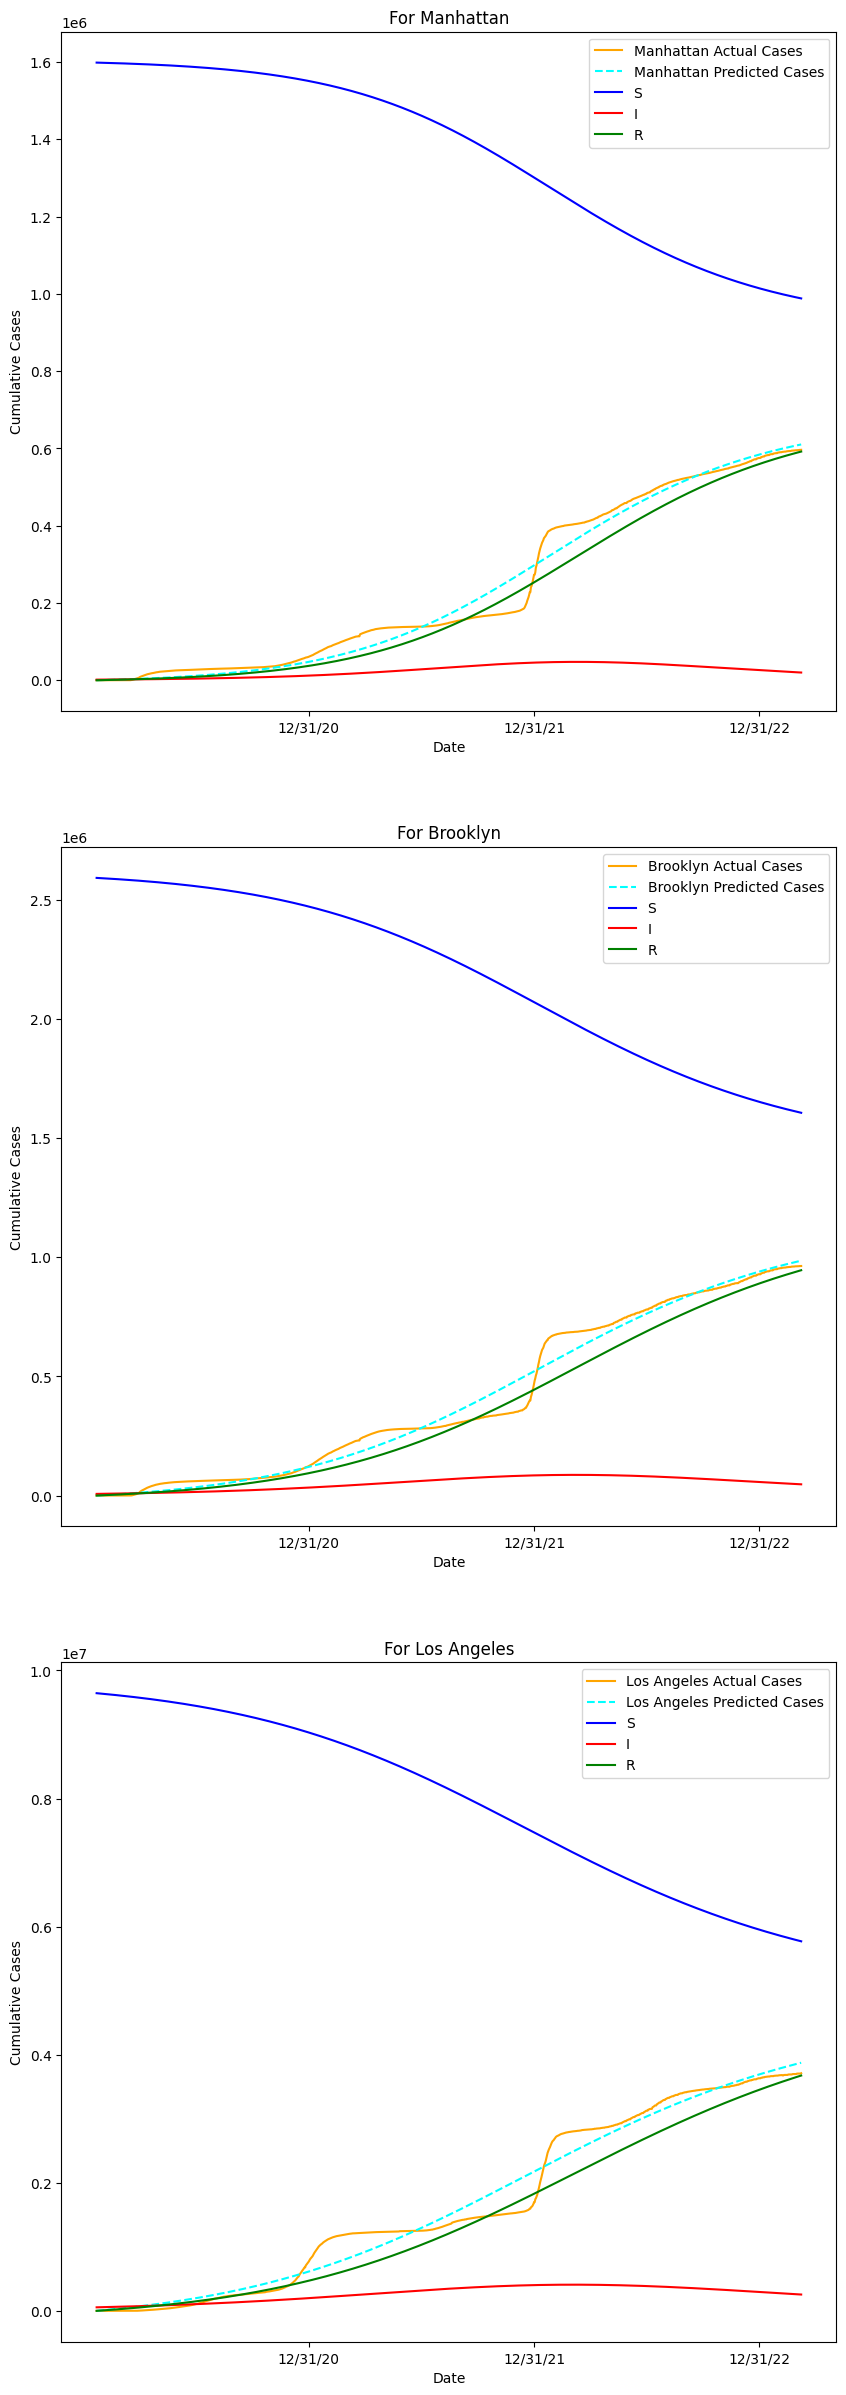

In [271]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30)) 
ax1.plot(Timeline, NY, label='Manhattan Actual Cases', color='orange')
ax1.plot(Timeline, solution_manhattan[:, 3] * population_manhattan, label='Manhattan Predicted Cases', color='cyan', linestyle='--')
ax1.plot(Timeline, solution_manhattan[:, 0] * population_manhattan, label='S', color='blue')
ax1.plot(Timeline, solution_manhattan[:, 1] * population_manhattan, label='I', color='red')
ax1.plot(Timeline, solution_manhattan[:, 2] * population_manhattan, label='R', color='green')
ax2.plot(Timeline, BK, label='Brooklyn Actual Cases', color='orange')
ax2.plot(Timeline, solution_brooklyn[:, 3] * population_brooklyn, label='Brooklyn Predicted Cases', color='cyan', linestyle='--')
ax2.plot(Timeline, solution_brooklyn[:, 0] * population_brooklyn, label='S', color='blue')
ax2.plot(Timeline, solution_brooklyn[:, 1] * population_brooklyn, label='I', color='red')
ax2.plot(Timeline, solution_brooklyn[:, 2] * population_brooklyn, label='R', color='green')
ax3.plot(Timeline, LA, label='Los Angeles Actual Cases', color='orange')
ax3.plot(Timeline, solution_la[:, 3] * population_la, label='Los Angeles Predicted Cases', color='cyan', linestyle='--')
ax3.plot(Timeline, solution_la[:, 0] * population_la, label='S', color='blue')
ax3.plot(Timeline, solution_la[:, 1] * population_la, label='I', color='red')
ax3.plot(Timeline, solution_la[:, 2] * population_la, label='R', color='green')
ax1.set_xlabel('Date')
ax2.set_xlabel('Date')
ax3.set_xlabel('Date')
ax1.set_ylabel('Cumulative Cases')
ax2.set_ylabel('Cumulative Cases')
ax3.set_ylabel('Cumulative Cases')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_title('For Manhattan')
ax2.set_title('For Brooklyn')
ax3.set_title('For Los Angeles')
ax1.set_xticks(['12/31/20','12/31/21','12/31/22'])
ax2.set_xticks(['12/31/20','12/31/21','12/31/22'])
ax3.set_xticks(['12/31/20','12/31/21','12/31/22'])
plt.show()

In [273]:
print(f"Manhattan: R_0(beta/gamma)={beta_manhattan/gamma_manhattan}")
print(f"Brooklyn: R_0(beta/gamma)={beta_brooklyn/gamma_brooklyn}")
print(f"Los Angeles: R_0(beta/gamma)={beta_la/gamma_la}")

Manhattan: R_0(beta/gamma)=1.3001303724322213
Brooklyn: R_0(beta/gamma)=1.3152045928823084
Los Angeles: R_0(beta/gamma)=1.3559474183657745


The R_0 is about 1.3. It means that the basic reproduction number for the disease under consideration is about 1.3. This implies that, on average, each infected individual is expected to infect about 1.3 other individuals in a completely susceptible population.

For COVID-19, the estimated R_0 values vary across different regions and time periods, but many studies suggest that the R_0 value lies between 2 and 3, with some estimates even higher. I think the lower R_0 may be because big cities have better medical facilities leading to higher cure rates, or some other factors such as incomplete data, model or method problems, approximate and fixed population size, etc.